In [1]:
from typing import Tuple, Optional
from data.hysteresis import hysteresis_ode, simulate_steady_state
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

from scipy.integrate import solve_ivp
from stabnode.data import TrajectoryDataset
from stabnode.node import StabNODE, Felu, Gelu
from stabnode.utils import _load_loop_wrapper, set_global_seed
from scipy.interpolate import interp1d

# from torchdiffeq import odeint
import torchode 
from torchode import solve_ivp
import time
import random


# def set_global_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)

#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

#     # check to see if any torch operatiosn introduce randomness
#     torch.use_deterministic_algorithms(True, warn_only=True)
seed=1
set_global_seed(seed)


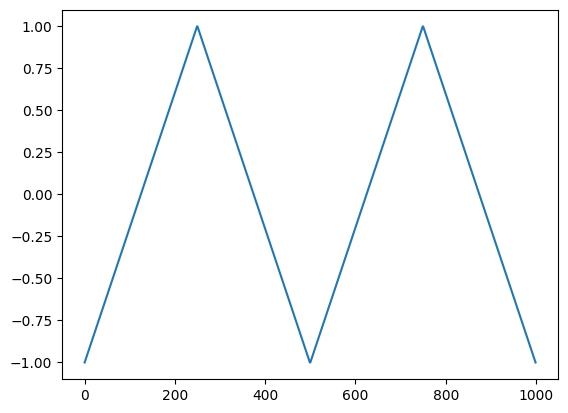

In [2]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam_np = np.hstack((lam_increase,lam_decrease))
repeat = 1
for _ in range(repeat):
    lam_np = np.hstack((lam_np, lam_np))
plt.plot(lam_np)
plt.show()

In [3]:
end = 20
t_eval = np.linspace(0,end,101)
# t_eval = None
X, lam, t = simulate_steady_state(lam_np, x0=-1.3,t_span=[0,end], t_eval=t_eval)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X.T)
X_scaled = scaler.transform(X.T).T
X_scaled = torch.tensor(X_scaled, dtype=torch.float32, device='cpu')

In [5]:
sample_rate=100
train_idx = torch.arange(0,len(t),sample_rate)
train_idx
X_train = X_scaled[:,train_idx]
t_train = t[train_idx]
lam_train = lam[train_idx]
X_train.shape, X_scaled.shape

(torch.Size([1, 1001]), torch.Size([1, 100001]))

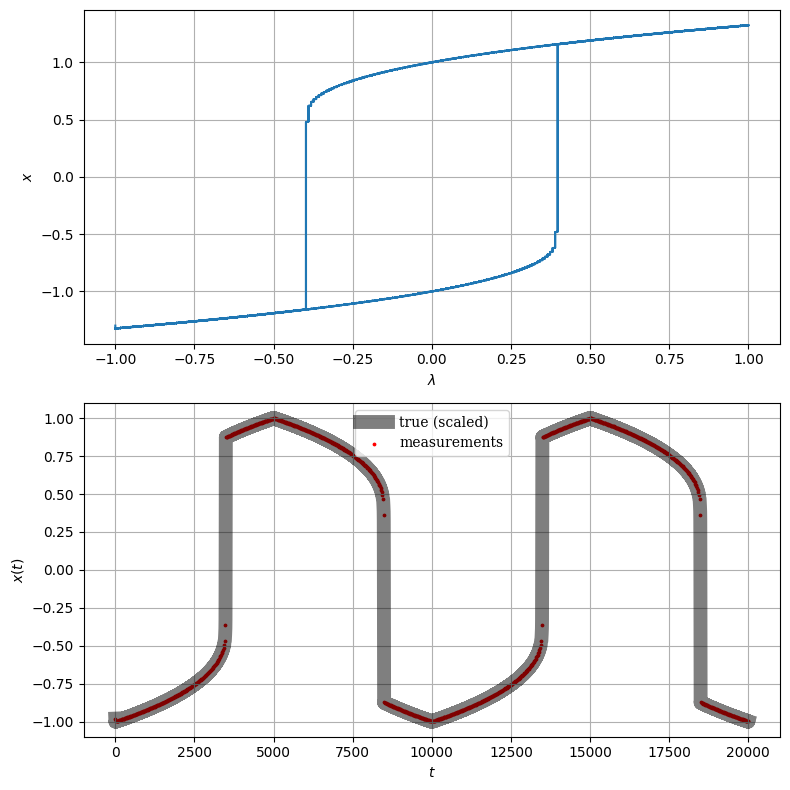

In [6]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
ax1.plot(lam, X[0,:])
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel(r"$x$")
ax1.grid(True)

ax2.plot(t, X_scaled[0,:], lw=10,c='black', alpha=0.5, label="true (scaled)")
ax2.scatter(t_train, X_train[0,:],c='red',s=3, label="measurements")
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$x(t)$")
ax2.grid(True)
ax2.legend(prop={'family':'serif'})
plt.tight_layout()
plt.show()

In [7]:
window_size = 501
window_size = None
train_dataset = TrajectoryDataset(X_train.T, t_train, window_size=window_size)
len(train_dataset)

1

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle=True, num_workers=0)
len(train_loader)

1

In [9]:
f = Felu(1,1,4)
g = Gelu(2,1,2)
model = StabNODE(f,g).to('cpu')

In [10]:
interp_lam = interp1d(t.numpy(), lam.numpy(), axis=0, kind='linear')

def control_func(t: torch.Tensor):
    t_scalar = t.item()
    lam_t = torch.tensor(interp_lam(t_scalar), dtype=torch.float32)
    return lam_t.unsqueeze(0)

### Write new model trainer with  `torchode.solve_ivp`

In [11]:
n_epochs = 10
lr = 1e-2
show_progress = True
solve_method = 'dopri5'
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)


loop_wrapper = _load_loop_wrapper(show_progress)
loop_wrapper2 = _load_loop_wrapper(True)

model.train()
losses = []
times = []

Xi_epoch_predictions = []
Tis_epoch = []
for epoch in loop_wrapper(range(n_epochs)):
    t1 = time.time()
    epoch_loss = 0.0
    num_batches = 0
    epoch_losses = []

    Xi_predictions = []
    Tis = []
    for Xi, Ti, x0i in loop_wrapper2(train_loader):
        Xi = Xi.squeeze() # [batch, time, dim]
        Ti = Ti.squeeze()

        if not x0i.requires_grad:
            x0i = x0i.clone().detach().requires_grad_()


        opt.zero_grad()

        sol = solve_ivp(
            f=lambda t, x: model(t, x, control_func),
            y0=x0i,
            t_eval=Ti,
            method=solve_method
        )

        Xi_pred = sol.ys.squeeze()
        Xi_predictions.append(Xi_pred)
        Tis.append(Ti)
        loss = loss_criteria(Xi_pred, Xi)

        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1

    Xi_epoch_predictions.append(Xi_predictions)
    Tis_epoch.append(Tis)
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)

    t2 = time.time()
    times.append(t2 - t1)

    # if avg_loss < 0.01:
    #     break

    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
# for test_Xi_pred in Xi_predictions:
#     test = test_Xi_pred.detach().numpy()
#     blowup_idx = np.where(np.isnan(test))[0]
#     print(blowup_idx)
#     print(test[blowup_idx])
#     print()

In [13]:
# fig, ax = plt.subplots(1,1, figsize = (10,5))

# ax.plot(t, X_scaled[0,:], lw=10,c='black', alpha=0.4, label="true (scaled)")
# ax.scatter(t_train, X_train[0,:],c='red',s=3, label="measurements")
# ax.set_xlabel(r"$t$")
# ax.set_ylabel(r"$x(t)$")
# ax.set_ylim(-1.1,1.1)
# ax.grid(True)

# for idx in range(len(Tis)):
#     ax.plot(Tis[idx], Xi_predictions[idx].detach().numpy(), linestyle='--')
# ax.legend()
# ax.set_title(f"Epoch 1, sample size {len(X_train.T)}/ {len(X_scaled.T)}")

# plt.suptitle(r"Simple Hystersis Training: torchode", family='serif',size=20)
# plt.savefig(f"torchode_training_epochs_{n_epochs}_batches_{len(train_loader)}_sover_{solve_method}.png")
# plt.show()

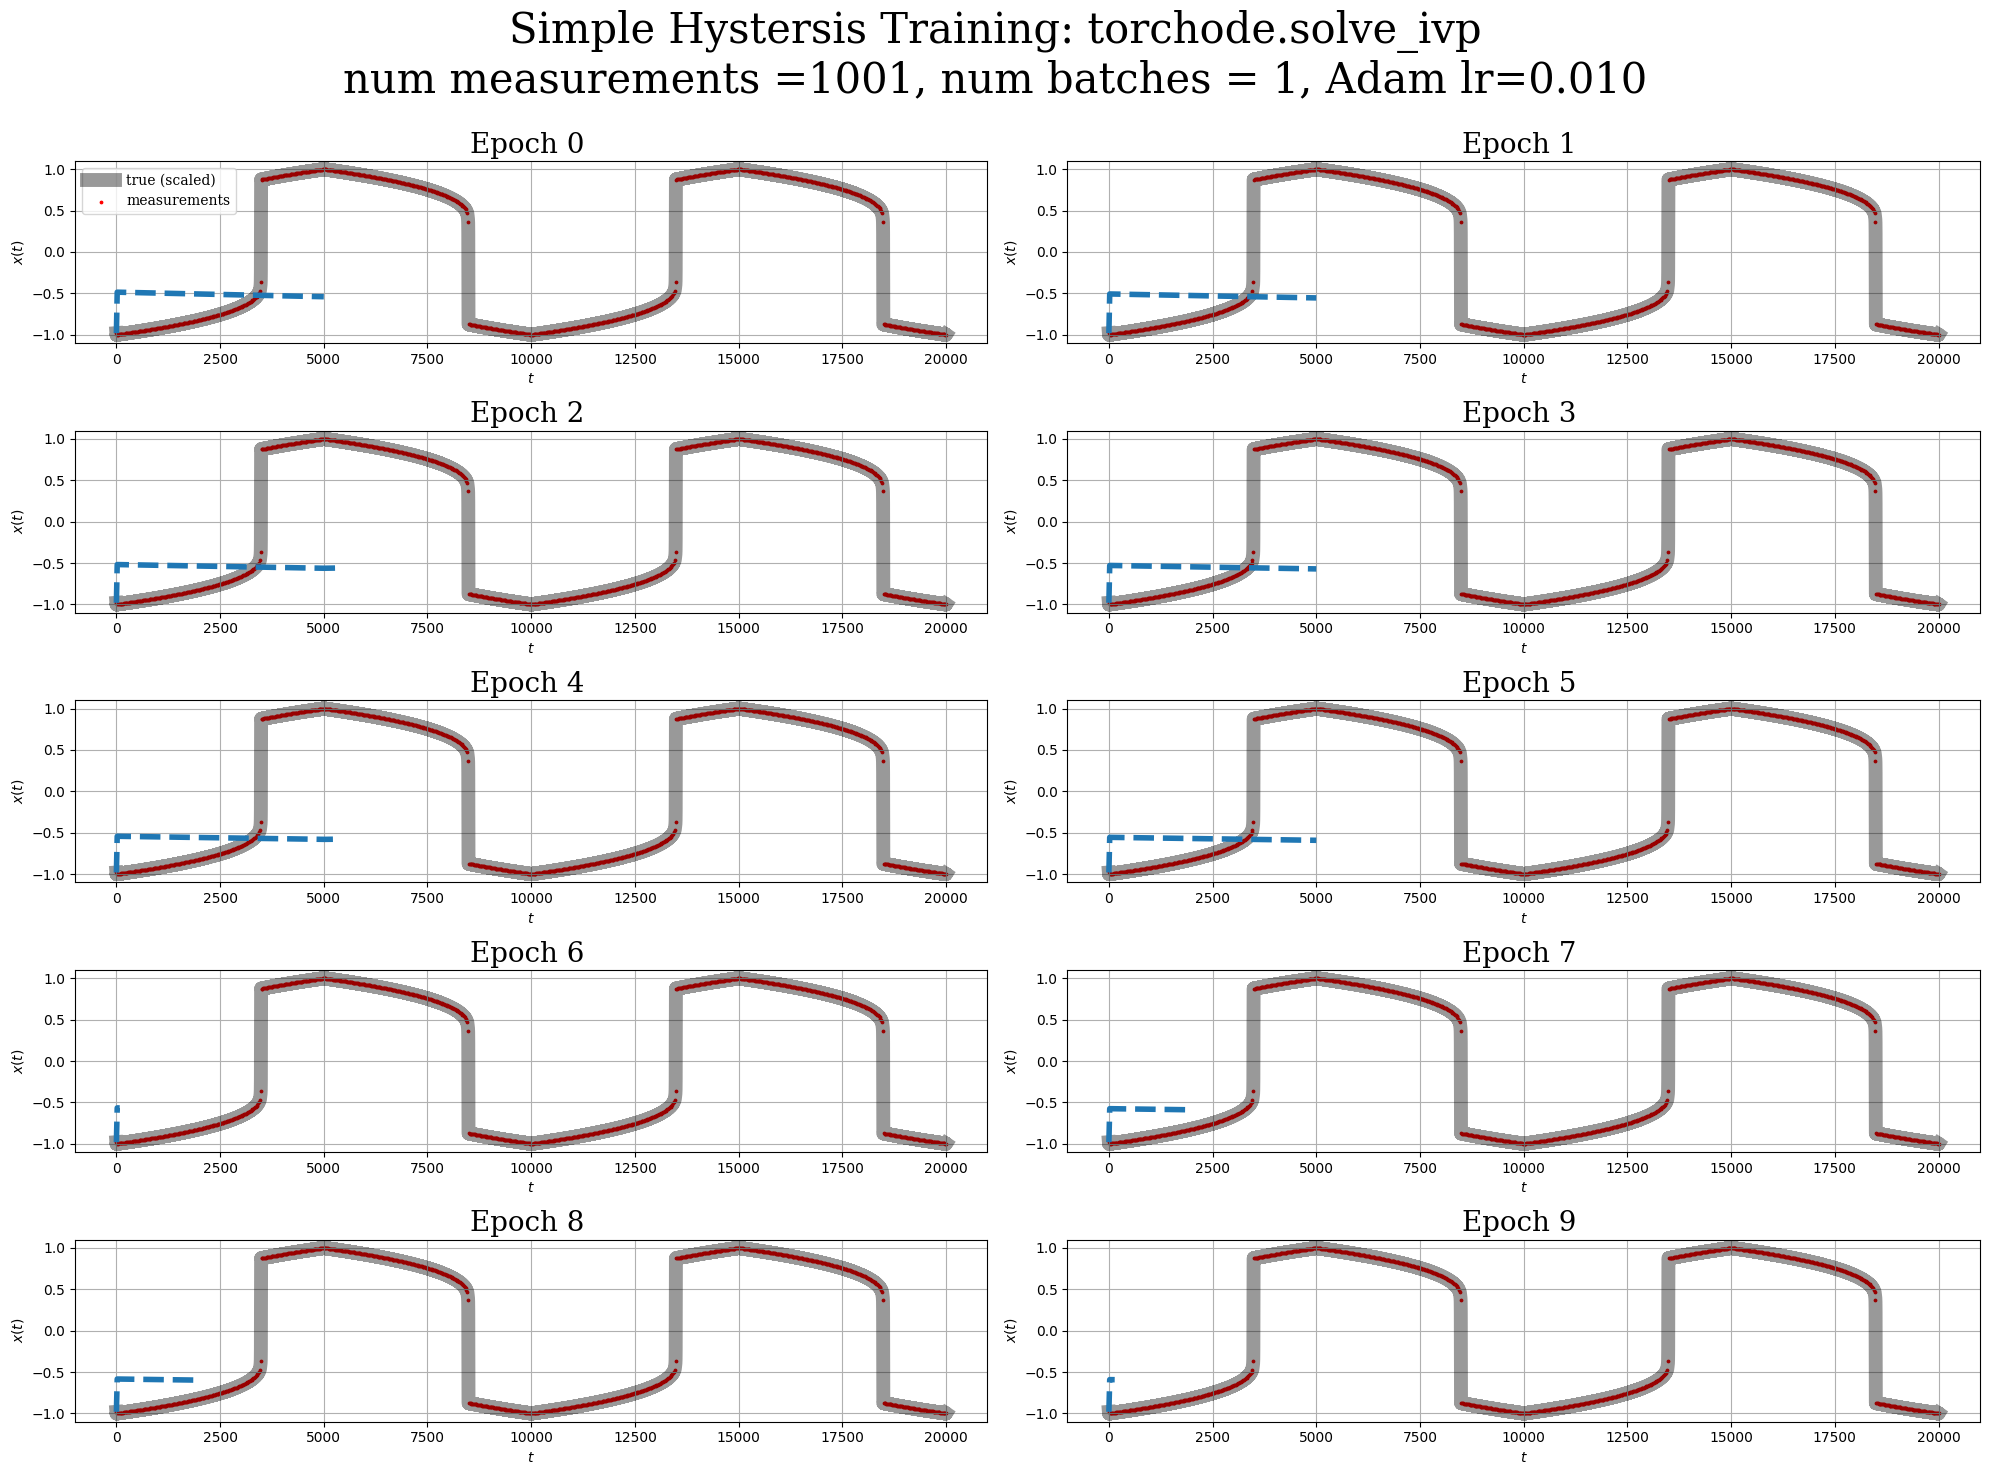

In [14]:
fig, axs = plt.subplots(5,2,figsize=(20,3*len(Xi_epoch_predictions)//2))

batch_cuttoff = 10
axs = axs.flatten()
for idx,ax in enumerate(axs):
    ax.plot(t, X_scaled[0,:], lw=10,c='black', alpha=0.4, label="true (scaled)")
    ax.scatter(t_train, X_train[0,:],c='red',s=3, label="measurements")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x(t)$")
    ax.set_ylim(-1.1,1.1)
    ax.grid(True)
    ax.set_title(f"Epoch {idx} ", family='serif',size=20)

    Xi_epoch_i = Xi_epoch_predictions[idx]
    Tis_epoch_i = Tis_epoch[idx]

    if len(Xi_epoch_i) >1:
        batch_cuttoff = np.min((batch_cuttoff, len(Xi_epoch_i)))
        Xi_epoch_i = Xi_epoch_i[:batch_cuttoff]
        Tis_epoch_i=Tis_epoch[idx][:batch_cuttoff]

    for xi, ti in zip(Xi_epoch_i, Tis_epoch_i):
        ax.plot(ti, xi.detach().numpy(),linestyle='--',lw=4)
    
    if idx ==0:
        ax.legend(prop={'family':'serif'})

plt.suptitle(f"Simple Hystersis Training: torchode.solve_ivp\nnum measurements ={len(X_train.T)}, num batches = {len(train_loader)}, Adam lr={lr:.3f}", family='serif',size=30)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(f"torchode_training_epochs_{n_epochs}_batches_{len(train_loader)}_sover_{solve_method}_seed_{seed}_lr_{lr}.png")
plt.show()

In [15]:
losses

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

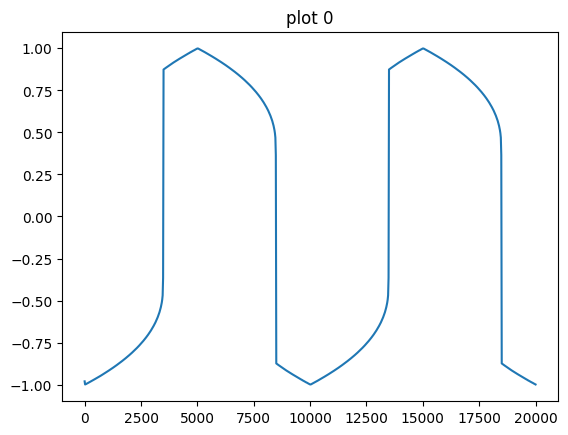

0: tensor([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.],
       dtype=torch.float64)


In [16]:
for idx,(Xi, ti, x0) in enumerate(train_loader):
    plt.title(f"plot {idx}")
    plt.plot(ti.squeeze(), Xi.squeeze())
    plt.show()
    print(f"{idx}: {ti.squeeze()[:10]}")

In [17]:
solve_method = 'dopri5'
for Xi, Ti, x0i in train_loader:
    sol = solve_ivp(
        f=lambda t, x: model(t, x, control_func),
        y0=x0i,
        t_eval=Ti,
        method=solve_method
    )

In [18]:
sol.status

tensor([4])

In [19]:
sol.ys[0,:10,0]

tensor([-0.9806, -0.5975, -0.5976, -0.5978, -0.5979, -0.5980, -0.5982, -0.5983,
        -0.5984,     nan], grad_fn=<SelectBackward0>)

In [20]:
sol.ys.requires_grad

True

In [21]:
x0i.grad

In [22]:
sol.message

AttributeError: 'Solution' object has no attribute 'message'

ImportError: cannot import name 'available_solvers' from 'torchode' (/Users/Malachite/Documents/github/stable_node_control/.venv/lib/python3.12/site-packages/torchode/__init__.py)